In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import george
from george import kernels
import scipy.optimize as op
import emcee

In [13]:
newdata = pd.read_table('PDCMAP.txt', sep='\s+')

In [14]:
alltime= np.array(newdata['Time'], 'd')
allflux = np.array(newdata['Pdcmap'], 'd')
allquarter = np.array(newdata['Quarter'], 'd')

55003 64024


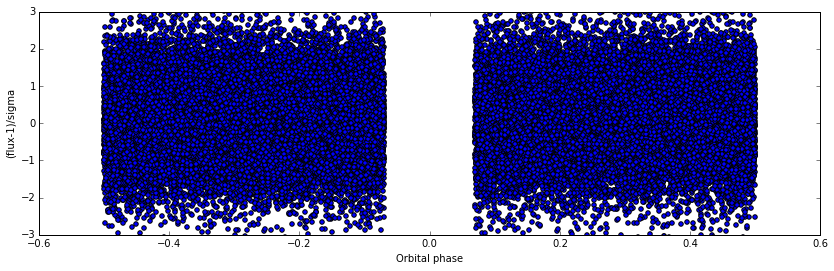

In [18]:
flag = np.zeros(len(alltime), dtype=bool)
quarters = np.unique(allquarter)

# Renormalize each quarter and remove outliers
for q in quarters:
    sel = allquarter == q
    errorf = np.std(allflux[sel])
    medianf = np.median(allflux[sel])
    finsel = np.logical_and(allquarter == q, (np.abs(allflux-medianf) <= 4.0*errorf))
    allflux[finsel] = allflux[finsel]/np.median(allflux[finsel])
    flag[finsel] = True
    
# Remove points in transit
t0 = 53.1910
p = 0.6892099

phasesaux = (alltime-t0)/p
phases = phasesaux - np.around(phasesaux)
flag[np.abs(phases) < 0.07]= False
flag[allquarter < -1]= False


    
#Retain the right points
print np.sum(flag), len(flag)
time = alltime[flag]
flux = allflux[flag] -1.0
flux = flux/np.std(flux)
quarter = allquarter[flag]
phases = phases[flag]

#plot the folded light curve to make sure we removed transits
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(1,1,1)
ax.scatter(phases, flux)
plt.ylim([-3,3]) 
ax.set_ylabel('(flux-1)/sigma')
ax.set_xlabel('Orbital phase')

In [19]:
interval = 1.0 # sum invertal in days
start = np.min(time) + 0.5*interval
end = (np.around((np.max(time)-start)/interval) + 1)*interval + start
numint = (end-start)/interval

newcenters = np.linspace(start, end, numint+1, endpoint=True)
newtimes = np.empty_like(newcenters)
newfluxes = np.empty_like(newtimes)
numpoints = np.empty_like(newtimes)
newerrors = np.empty_like(newtimes)
newquarter = np.empty_like(newtimes)

for i, t0 in enumerate(newtimes):
    selected = np.abs(time-newcenters[i]) < interval*0.5
    numpoints[i] = np.sum(selected)
    if numpoints[i] > 1:
        selflux = flux[selected]
        seltimes= time[selected]
        t1 = np.median(seltimes)
        newtimes[i]  = t1
        result = np.polyfit(seltimes-t1, selflux, 1)
        newfluxes[i] = result[1] 
        newerrors[i] = np.std(selflux-result[1]-result[0]*(seltimes-t1))
        newquarter[i] = np.median(quarter[selected])


        
cadence = 29.42/(60.0*24)
        
newtimes = newtimes[numpoints > interval*0.75/cadence]
newfluxes = newfluxes[numpoints > interval*0.75/cadence]
newerrors = newerrors[numpoints > interval*0.75/cadence]

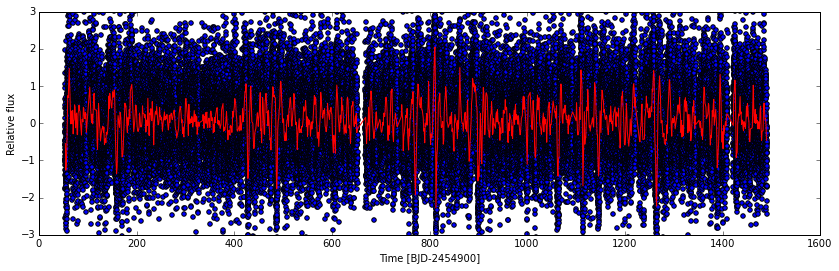

In [20]:
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(1,1,1)
ax.scatter(time, flux)
plt.xlim([0,1600]) 
plt.ylim([-3,3]) 
ax.set_xlabel('Time [BJD-2454900]')
ax.set_ylabel('Relative flux')
ax.plot(newtimes, newfluxes, 'r')

In [21]:
def lnlike(theta, time, flux, error):
    prot, h, sigma, alpha = theta 

    gp = george.GP(kernels.WhiteKernel(sigma**2) + (kernels.ExpSquaredKernel(alpha**2)*(kernels.CosineKernel(prot))*h**2))
    gp.compute(time, error)
    return gp.lnlikelihood(flux)

In [22]:
def lnprior(theta):
    prot, h, sigma, alpha = theta 
    if (0< sigma) and (0 < alpha <= 100.0) and (0 <= h) and (0 < prot < 100):
        return 0.0
    return -np.inf

In [23]:
def lnprob(theta, time, flux, error):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, time, flux, error)

In [30]:
nll = lambda *args: -lnprob(*args)
result = op.minimize(nll, [32.0, 20.0, .1, 1.0], 
                     args=(newtimes, newfluxes, 0.1*newerrors), tol=0.01, options={'disp': True, 'maxiter':100000})
prot_ml, h_ml,sigma_ml, alpha_ml = result["x"]  
print result["x"]

         Current function value: 896.939139
         Iterations: 15
         Function evaluations: 279
         Gradient evaluations: 44
[  9.93467499e+01   7.58544883e-02   4.84884907e-01   2.11913718e+01]


In [31]:
ndim, nwalkers = 4, 100
pos = [result["x"]*(1+5e-3*np.random.randn(ndim)) for i in range(nwalkers)]

In [32]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(newtimes, newfluxes, newerrors))
sampler.run_mcmc(pos, 100)

(array([[  5.75887528e+01,   2.22324119e-02,   5.61899519e-02,
           2.06819373e+01],
        [  7.91553092e+01,   1.41173462e-02,   1.84390990e-02,
           9.02145718e+01],
        [  9.24429733e+01,   6.11024933e-02,   8.62539364e-02,
           4.20481858e+01],
        [  2.24567784e+01,   7.02967622e-02,   3.64017128e-02,
           2.38771172e+00],
        [  8.78116397e+01,   2.01689778e-02,   6.67803391e-02,
           6.71579055e+01],
        [  8.77747064e+01,   3.39878898e-02,   1.69486473e-02,
           4.97199585e+01],
        [  4.14952134e+01,   6.00600174e-02,   4.53788965e-02,
           8.62880180e+01],
        [  7.75748579e+01,   1.68285857e-01,   2.56345981e-02,
           4.03077283e+00],
        [  6.12047864e+01,   1.39552691e-02,   5.18648025e-02,
           5.73530875e+01],
        [  3.34391814e+01,   4.32522019e-02,   4.69525336e-02,
           7.63911064e+01],
        [  4.06724472e+01,   5.67788122e-02,   3.16684447e-02,
           7.15143052e+00],

In [33]:
samples = sampler.chain[:, 10:, :].reshape((-1, ndim)) #Burn in portion to remove (currently %10)

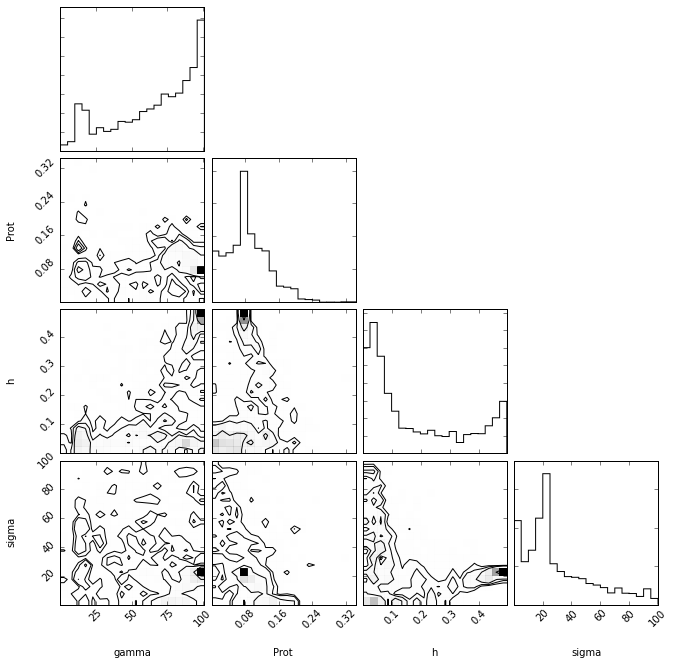

In [34]:
import triangle
fig = triangle.corner(samples, labels=["gamma", "Prot", "h", "sigma", "alpha"]) #truths=[m_true, b_true, np.log(f_true)   , 
fig.savefig("triangle.png")

In [35]:
(prot_mcmc, h_mcmc, sigma_mcmc, alpha_mcmc) = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                                  zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))

In [36]:
print('Prot value {0:3.2f} +{1:3.2f} - {1:3.2f}' .format(prot_mcmc[0],prot_mcmc[1], prot_mcmc[2] ))
print('Alpha value {0:3.2f} +{1:3.2f} - {1:3.2f}' .format(alpha_mcmc[0],alpha_mcmc[1], alpha_mcmc[2] ))

Prot value 72.76 +22.65 - 22.65
Alpha value 21.80 +35.14 - 35.14
